# Project 3 - CAM을 만들고 평가해 보자

### 목표
- **ResNet50 + GAP + DenseLayer 결합된 CAM 모델 구현**
- **CAM 방식과 Grad-CAM 방식의 class activation map 시각화**
- **CAM과 Grad-CAM의 object localization 성능 비교분석**

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import os
import copy
import cv2
from PIL import Image

c:\Users\JDINO\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tf.config.list_physical_devices('GPU')

[]

### (1) 데이터 준비

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
    data_dir='../tensorflow_datasets'
)

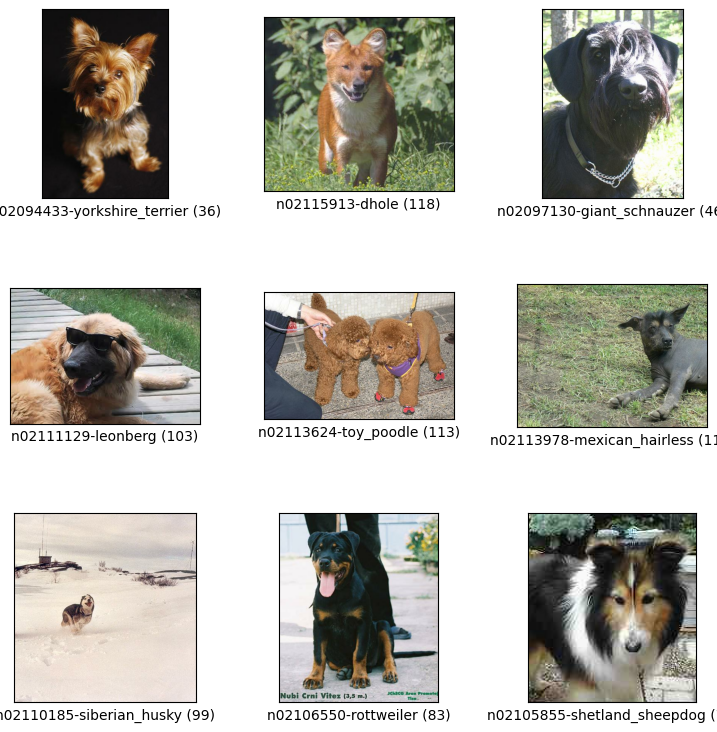

In [4]:
_ = tfds.show_examples(ds_train, ds_info)

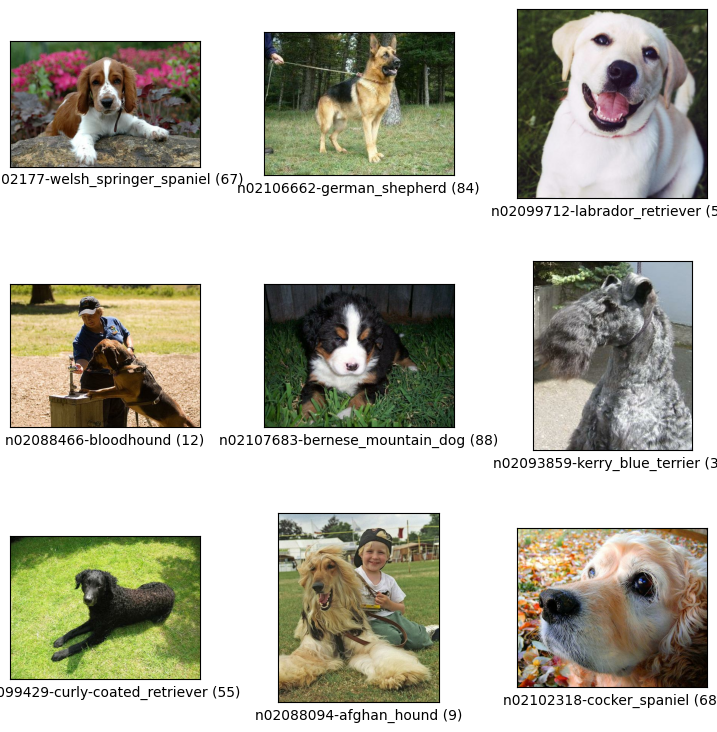

In [5]:
_ = tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})

### (2) 데이터 전처리

In [7]:
def normalize_and_resize_img(data):
    image = tf.image.resize(data['image'], (224, 224))
    data['image'] = tf.cast(image, tf.float32) / 255.
    return data['image'], data['label']

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [17]:
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test, True)

for i in ds_train_norm.take(1):
    print(i[0].shape)
    print(i[1].shape)

(16, 224, 224, 3)
(16,)


### (3) ResNet-50 사전 학습 모델 불러오기

In [13]:
num_classes = ds_info.features['label'].num_classes

In [14]:
# ResNet-50 불러오기
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,   # 마지막 fully connected layer 제외
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg'        # Global Average Pooling
)

# Dense Layer
x = base_model.output
output = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

cam_model = keras.Model(inputs=base_model.input, outputs=output, name="cam_model")

In [15]:
cam_model.summary()

Model: "cam_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

### (4) 모델 학습

In [16]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy']
)

In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)